# Based on analysis by ProPublica

[the methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/), [the code](https://github.com/propublica/compas-analysis)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
raw_data = pd.read_csv('compas-scores-two-years.csv')
len(raw_data)

7214

In [3]:
raw_data.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

(From the ProPublica notebook...)

However not all of the rows are useable for the first round of analysis.

There are a number of reasons remove rows because of missing data:
* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [3]:
%%R
df <- dplyr::select(raw_data, age, c_charge_degree, race, age_cat, score_text, sex, priors_count, 
                    days_b_screening_arrest, decile_score, is_recid, two_year_recid, c_jail_in, c_jail_out) %>% 
        filter(days_b_screening_arrest <= 30) %>%
        filter(days_b_screening_arrest >= -30) %>%
        filter(is_recid != -1) %>%
        filter(c_charge_degree != "O") %>%
        filter(score_text != 'N/A')
nrow(df)

[1] 6172


In [4]:
# My translation of their R code...
#df = raw_data[
#    ('age, c_charge_degree, race, age_cat, score_text, sex, priors_count, days_b_screening_arrest, '
#    'decile_score, is_recid, two_year_recid, c_jail_in, c_jail_out').split(', ')]
df = (
    raw_data
    .query("days_b_screening_arrest <= 30")
    .query('days_b_screening_arrest >= -30')
    .query("is_recid != -1")
    .query('c_charge_degree != "O"')
    .query("score_text != 'N/A'")
).copy()
len(df)

6172

In [17]:
samp = df.sample(50, random_state=0)

In [18]:
samp.query("is_recid == 1").drop(["c_jail_in", "c_jail_out", "c_case_number"], axis=1).to_clipboard()
#.iloc[1, 5:]

In [23]:
df['sex'] = df['sex'].map({"Male": "M", "Female": "F"})

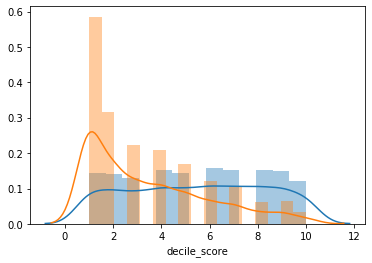

In [40]:
sns.distplot(df[df['is_recid'] == 1]['decile_score'], label='Recid')
sns.distplot(df[df['is_recid'] == 0]['decile_score'], label='!Recid')

In [41]:
df['binary_prediction'] = np.where(df['decile_score'] >= 4, "Yes", "No")
df['binary_prediction_2'] = np.where(df['decile_score'] >= 6, "Yes", "No")

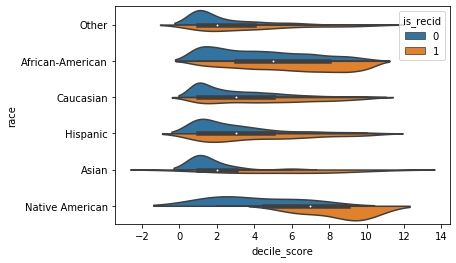

In [34]:
sns.violinplot(hue='is_recid', x='decile_score', y='race', data=df, split=True)

In [50]:
df['juv_crimes'] = df.eval('juv_fel_count + juv_misd_count + juv_other_count')
(
    df
    [['sex', 'age', 'juv_crimes', 'priors_count', 'is_recid', 'binary_prediction', 'binary_prediction_2', 'decile_score']]
    .sample(n=38, random_state=1)
    .sort_values('is_recid')
    .rename(columns={
# 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 
#         'juv_fel_count': "Juvenile Felonies",
#         'juv_misd_count': "Juvenile Misdemeanors",
#         'juv_other_count': "Juv Other",
        'juv_crimes': "Juvenile Crimes",
        'priors_count': "# Prior Crimes",
        'is_recid': "Recidivated",
        'binary_prediction': "Judge A",
        'binary_prediction_2': "Judge B",
        'decile_score': "score"
    })
).to_clipboard(index=False)

In [20]:
import seaborn as sns

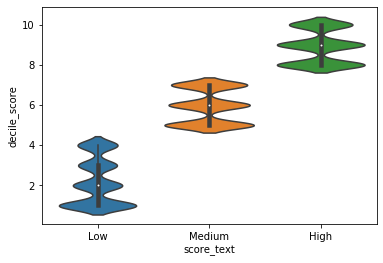

In [21]:
sns.violinplot(x='score_text', y='decile_score', data=df)